# Author: Стурейко Игорь
## Project: Geekbrains.Algorithms
## Lesson 03 - Дерево решений
## Date: 2020-09-02

In [1]:
import numpy as np
from matplotlib import pyplot as plt


import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

In [2]:
# Класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [3]:
# Класс листа

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction   

In [4]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [5]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [6]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [7]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels, criteria):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    if criteria == 'gini':
        current_q = gini(labels)
    else:
        current_q = entropy(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_q)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [8]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels, criteria):

    quality, t, index = find_best_split(data, labels, criteria)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, criteria)
    false_branch = build_tree(false_data, false_labels, criteria)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [9]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [10]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [11]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

## 1. В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.)

In [20]:
# ToDo: написать функцию критерия останова - количество листьев, количество используемых признаков, глубина дерева
# def classify_object(obj, node):

#     #  Останавливаем рекурсию, если достигли листа
#     if isinstance(node, Leaf):
#         answer = node.prediction
#         return answer

#     if obj[node.index] <= node.t:
#         return classify_object(obj, node.true_branch)
#     else:
#         return classify_object(obj, node.false_branch)

## 2. Для задачи классификации обучить дерево решений с использованием критериев разбиения Джини и Энтропия. Сравнить качество классификации, сделать выводы.

In [12]:
# Расчет критерия Энтропии

def entropy(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p * np.log2(p)
        
    return impurity

In [13]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification(n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=6)

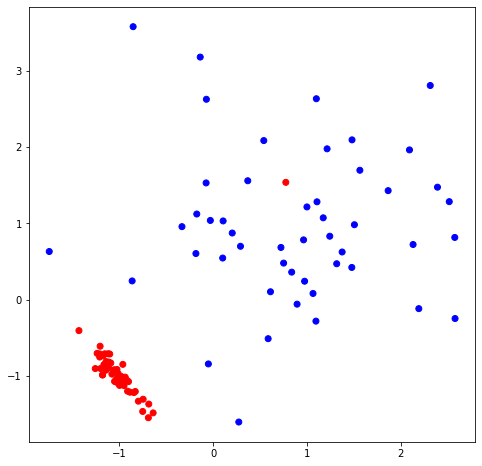

In [14]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

In [15]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 7)

In [18]:
criteria='entropy'
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels, criteria=criteria)
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

print(f'Критерий разбиения: {criteria}')
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print('Точность на обучающей выборке: \t{:5.10f}'.format(train_accuracy))
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
print('Точность на тестовой выборке: \t{:5.10f}\n'.format(test_accuracy))

criteria='gini'
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels, criteria=criteria)
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

print(f'Критерий разбиения: {criteria}')
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print('Точность на обучающей выборке: \t{:5.10f}'.format(train_accuracy))
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
print('Точность на тестовой выборке: \t{:5.10f}\n'.format(test_accuracy))

Критерий разбиения: entropy
Точность на обучающей выборке: 	97.1428571429
Точность на тестовой выборке: 	93.3333333333

Критерий разбиения: gini
Точность на обучающей выборке: 	97.1428571429
Точность на тестовой выборке: 	93.3333333333



### Разницы в точности модели при разных критериях не обнаружил, по видимому они дают очень близкое значение

## 3*. Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.